Comparison of DnCNN Variants for Image Denoising
================================================

This example demonstrates the solution of an image denoising problem
using different DnCNN variants.
<cite data-cite="zhang-2017-dncnn"/> DnCNN,
<cite data-cite="zhang-2021-plug"/> training denoiser with noise level as input.

Overview of different DnCNNs used in this script:
[6L, 6M, 6H, 17L, 17M, 17H] non-blind DnCNNs, where [6, 17] denote the
number of layers, and [L, M, H] represent noise level of the training
samples.

[6N, 17N] DnCNNs with addtional noise levels as inputs, where [6, 17]
denote the number of layers

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.random
from scico import metric, plot
from scico.denoiser import DnCNN
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Test different DnCNN variants on images with different noise levels

In [3]:
print("  σ   | variant | noisy image PSNR (dB)   | denoised image PSNR (dB)")
for σ in [0.06, 0.1, 0.2]:
    print("------+---------+-------------------------+-------------------------")
    for variant in ["6L", "6M", "6H", "6N", "17L", "17M", "17H", "17N"]:

        # Instantiate a DnCnn
        denoiser = DnCNN(variant=variant)

        # Generate a noisy image.
        noise, key = scico.random.randn(x_gt.shape, seed=0)
        y = x_gt + σ * noise

        if variant in ["6N", "17N"]:
            x_hat = denoiser(y, sigma=σ)
        else:
            x_hat = denoiser(y)

        x_hat = np.clip(x_hat, a_min=0, a_max=1.0)

        if variant[0] == "6":
            variant += " "  # add spaces to maintain alignment

        print(
            " %.2f | %s     |          %.2f          |          %.2f          "
            % (σ, variant, metric.psnr(x_gt, y), metric.psnr(x_gt, x_hat))
        )

  σ   | variant | noisy image PSNR (dB)   | denoised image PSNR (dB)
------+---------+-------------------------+-------------------------


 0.06 | 6L      |          24.43          |          33.80          


 0.06 | 6M      |          24.43          |          29.76          


 0.06 | 6H      |          24.43          |          26.86          


 0.06 | 6N      |          24.43          |          36.30          


 0.06 | 17L     |          24.43          |          33.82          


 0.06 | 17M     |          24.43          |          33.94          


 0.06 | 17H     |          24.43          |          26.32          


 0.06 | 17N     |          24.43          |          35.17          
------+---------+-------------------------+-------------------------


 0.10 | 6L      |          19.99          |          27.87          


 0.10 | 6M      |          19.99          |          27.45          


 0.10 | 6H      |          19.99          |          26.52          


 0.10 | 6N      |          19.99          |          33.09          


 0.10 | 17L     |          19.99          |          27.43          


 0.10 | 17M     |          19.99          |          31.82          


 0.10 | 17H     |          19.99          |          26.44          


 0.10 | 17N     |          19.99          |          28.44          
------+---------+-------------------------+-------------------------


 0.20 | 6L      |          13.97          |          18.70          


 0.20 | 6M      |          13.97          |          20.70          


 0.20 | 6H      |          13.97          |          24.78          


 0.20 | 6N      |          13.97          |          25.71          


 0.20 | 17L     |          13.97          |          18.37          


 0.20 | 17M     |          13.97          |          20.12          


 0.20 | 17H     |          13.97          |          25.97          


 0.20 | 17N     |          13.97          |          17.79          


Show reference and denoised images for σ=0.2 and variant=6N.

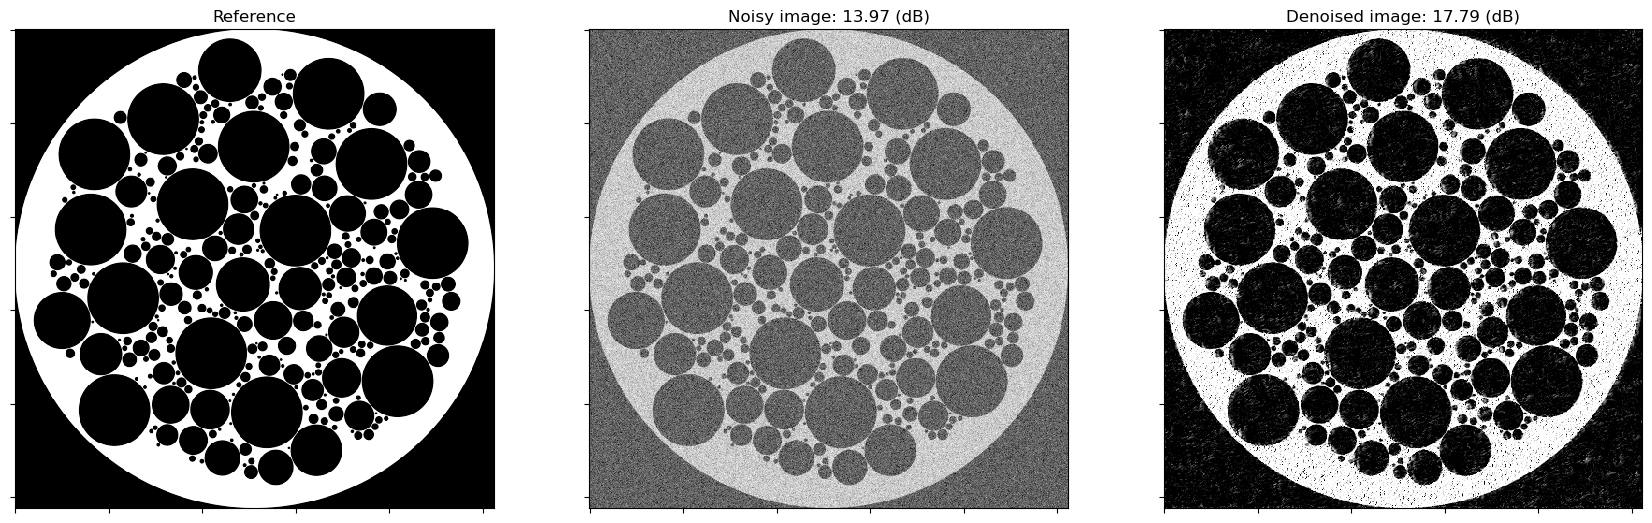

In [4]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(21, 7))
plot.imview(x_gt, title="Reference", fig=fig, ax=ax[0])
plot.imview(y, title="Noisy image: %.2f (dB)" % metric.psnr(x_gt, y), fig=fig, ax=ax[1])
plot.imview(x_hat, title="Denoised image: %.2f (dB)" % metric.psnr(x_gt, x_hat), fig=fig, ax=ax[2])
fig.show()